In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, copy

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image

import torchvision.transforms as transforms
from torchvision.models import vgg19,VGG19_Weights

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cpu')

In [143]:
imsize=512 if torch.cuda.is_available() else 128
imsize

128

In [144]:
loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [145]:

style_img = image_loader("images/picasso.jpg")
content_img = image_loader("images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

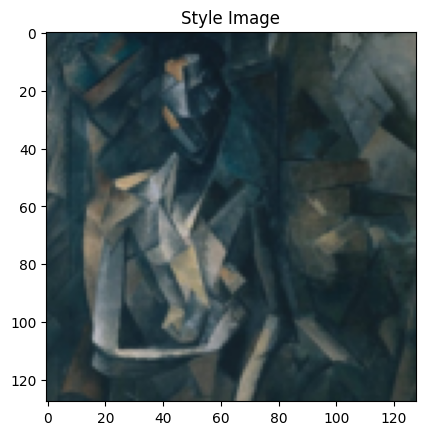

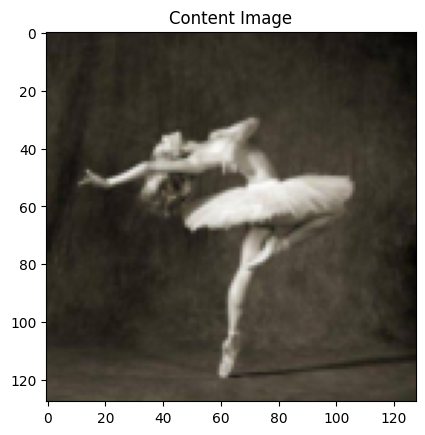

In [146]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)     
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [147]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [148]:
def gram_matrix(input):
    a,b,c,d=input.size()
    # a=batch size(=1), b=number of feature maps, (c,d)=dimensions of a f. map (N=c*d)
    features=input.view(a*b,c*d)
    G=torch.mm(features,features.t())
    # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps
    return G.div(a*b*c*d)
    

In [149]:
class StyleLoss(nn.Module):
    def __init__(self,target_feature):
        super(StyleLoss,self).__init__()
        self.target=gram_matrix(target_feature).detach()
    def forward(self,input):
        G=gram_matrix(input)
        self.loss=F.mse_loss(G,self.target)
        return input

In [150]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.to(device).eval()

In [151]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [152]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

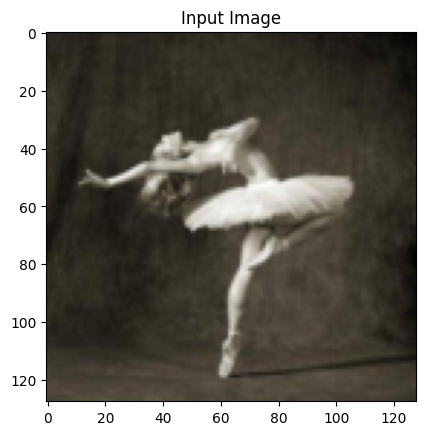

In [153]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [139]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [154]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = torch.tensor(0., device=device)
            content_score = torch.tensor(0., device=device)

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run[0]))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return loss

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


d:\Vegeta\Projects\DL projects\video style tranfer\env\lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run 50:
Style Loss : 27.640882 Content Loss: 9.808157

run 100:
Style Loss : 6.674675 Content Loss: 8.706364

run 150:
Style Loss : 3.593357 Content Loss: 7.928505

run 200:
Style Loss : 2.680503 Content Loss: 7.423980

run 250:
Style Loss : 2.214459 Content Loss: 7.110110

run 300:
Style Loss : 1.933510 Content Loss: 6.890347



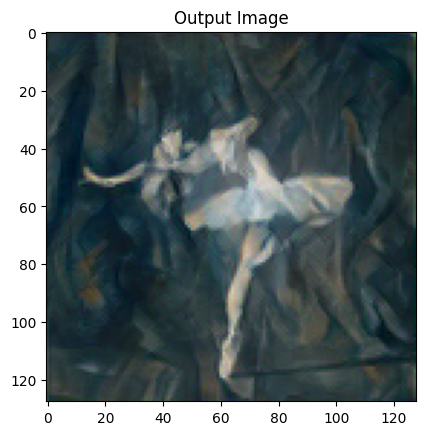

In [120]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

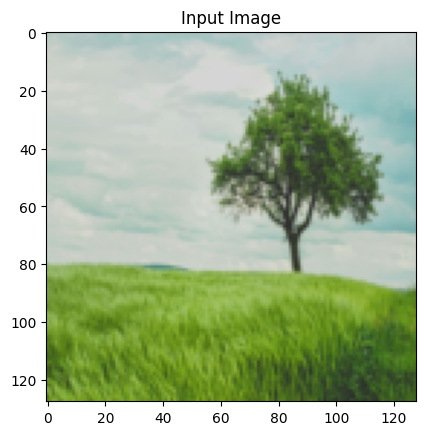

In [121]:
test_image=image_loader("images/nature.jpg")
test_input=test_image.clone()
plt.figure()
imshow(test_image, title='Input Image')

Building the style transfer model..
Optimizing..


d:\Vegeta\Projects\DL projects\video style tranfer\env\lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run 50:
Style Loss : 204.455627 Content Loss: 13.169467

run 100:
Style Loss : 107.035759 Content Loss: 14.389449

run 150:
Style Loss : 61.125740 Content Loss: 15.079613

run 200:
Style Loss : 37.303535 Content Loss: 14.351392

run 250:
Style Loss : 22.660032 Content Loss: 13.990544

run 300:
Style Loss : 13.163776 Content Loss: 13.181291



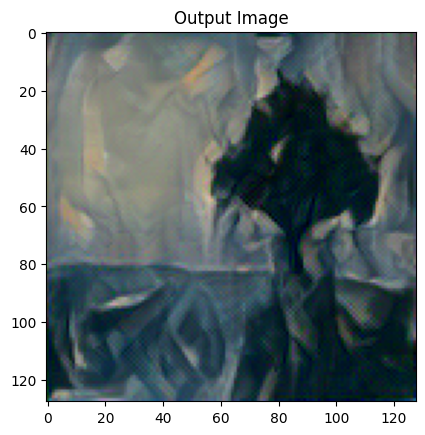

In [122]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, test_image, style_img, test_input)
plt.figure()
imshow(output, title='Output Image')


plt.ioff()
plt.show()

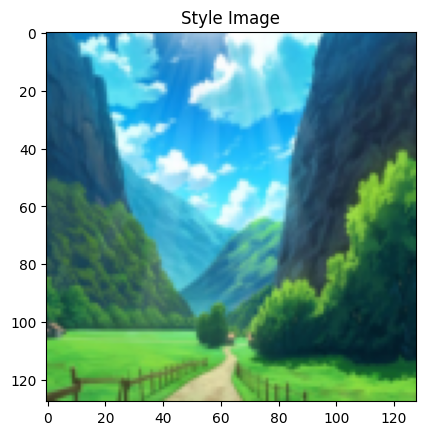

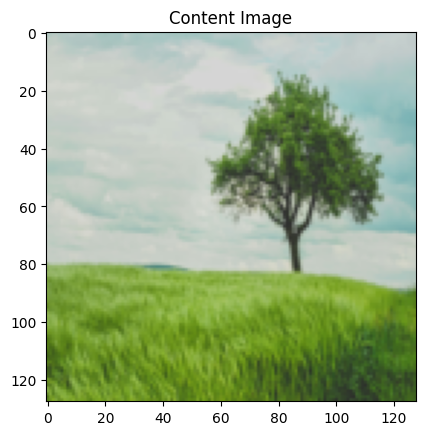

In [155]:
style_image=image_loader("images/anime nature.jpg")
content_img=image_loader("images/nature.jpg")
input_img=content_img.clone()
plt.figure()
imshow(style_image, title='Style Image')
plt.figure()
imshow(content_img, title='Content Image')


Building the style transfer model..
Optimizing..
run 50:
Style Loss : 177.960861 Content Loss: 19.835537

run 100:
Style Loss : 55.895493 Content Loss: 20.300312

run 150:
Style Loss : 26.993231 Content Loss: 20.627348

run 200:
Style Loss : 17.849695 Content Loss: 20.048100

run 250:
Style Loss : 13.440738 Content Loss: 19.394577

run 300:
Style Loss : 10.828345 Content Loss: 18.871801



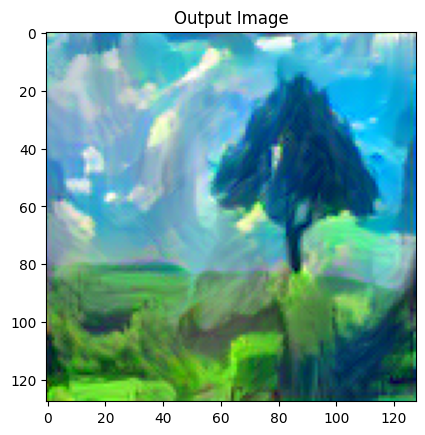

In [156]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_image, input_img)
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()